# Volume 3: Kalman Filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

## Kalman Filter Class

We implement a KalmanFilter class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

We write a method evolve() in the KalmanFilter class to generate a state and observation sequence by evolving the system from a given initial state.

We estimate a state sequence corresponding to a given observation sequence and initial state estimate with the estimate() method.

We write a function predict() for the class that predicts the next $k$ states given a current state estimate but in the absence of observations.

The function rewind() rewinds the system from a given state estimate, returning predictions for the previous states. 

In [3]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # set attributes
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
    
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        # initialize the sizes
        n = x0.shape[0]
        m = (self.H @ x0).shape[0]

        # initialize the output
        states = np.zeros((n,N))
        obs = np.zeros((m,N))
        states[:,0] = x0
        obs[:,0] = x0[:2]

        # iterate to compute the states and observations
        for i in range(1,N):
            states[:,i] = self.F @ states[:,i-1] + self.u + np.random.multivariate_normal(np.zeros(n),self.Q)
            obs[:,i] = self.H @ states[:,i] + np.random.multivariate_normal(np.zeros(m),self.R)

        return states, obs


    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        n = x0.shape[0]
        N = z.shape[1]

        # initialize the output
        output = np.zeros((n,N))
        output[:,0] = x0
        xk1 = x0
        pk1 = P0

        # iterate to compute the state estimates
        for i in range(1,N):
            # prediction step
            xk = self.F @ xk1 + self.u
            pk = self.F @ pk1 @ self.F.T + self.Q

            # update step
            yh = z[:,i] - self.H @ xk
            Sk = self.H @ pk @ self.H.T + self.R
            Kk = pk @ self.H.T @ inv(Sk)
            xk = xk + Kk @ yh
            pk = (np.eye(n) - Kk @ self.H) @ pk

            # save the estimate
            output[:,i] = xk

            # update the state
            xk1 = xk
            pk1 = pk

        return output
    
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        out = np.empty((x.shape[0],k))

        # iterate to compute the state estimates
        for i in range(k):
            out_i = self.F @ x + self.u
            out[:,i] = out_i
            x = out_i
        
        return out
    

    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        out = np.empty((x.shape[0],k))

        # iterate to compute the state estimates
        for i in range(k):
            out_i = inv(self.F) @ (x - self.u)
            out[:,i] = out_i
            x = out_i

        return out


## Application

We write the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to a projectile.

In [4]:
Q = np.eye(4) * 0.1
R = np.eye(2) * 5000

F = np.array([[1,0,0.1,0], 
              [0,1,0,0.1], 
              [0,0,1,0], 
              [0,0,0,1]])
H = np.array([[1,0,0,0], [0,1,0,0]])
u = np.array([0,0,0,-0.98])

kf = KalmanFilter(F,Q,H,R,u)

## Simulation

We simulate the true and observed trajectory of a projectile with an initial state.

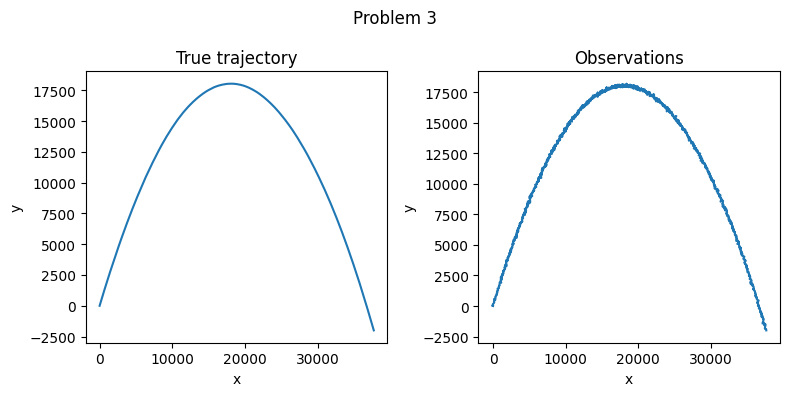

In [5]:
x0 = np.array([0,0,300, 600])
tsteps = 1250
states, obs = kf.evolve(x0,tsteps)

# plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[0,:], states[1,:])
plt.title("True trajectory")
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,2,2)
plt.plot(obs[0,:], obs[1,:], label="Observations")
plt.title("Observations")
plt.xlabel('x')
plt.ylabel('y')

plt.suptitle("Problem 3")
plt.tight_layout()
plt.show()

## updating the Model

We calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.
Using the initial state estimate, $P_{200} = 10^6\cdot Q$, and the Kalman Filter, we compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
We plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
We zoom in to see how well it follows the true path. 

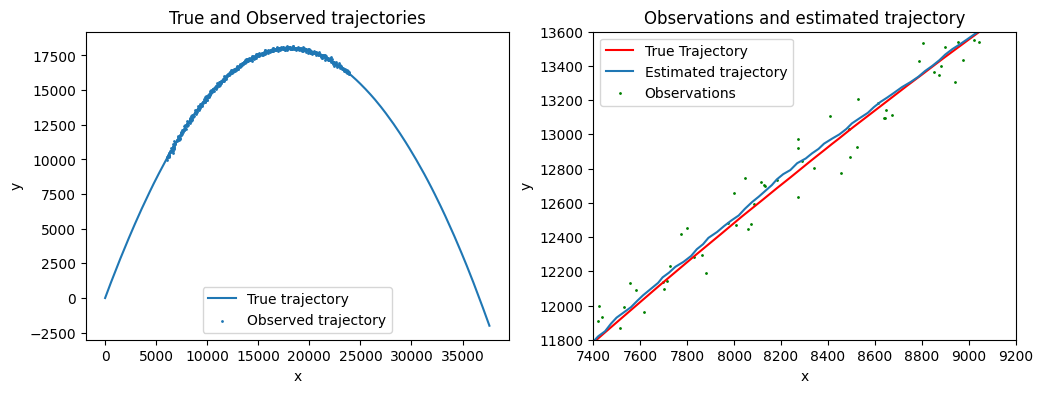

In [6]:
x0, y0 = obs[:, 200]
speed = np.diff(obs[:, 200:210], axis=1) / 0.1
vx0, vy0 = np.mean(speed, axis=1)

init = np.array([x0, y0, vx0, vy0])
P0 = 1e6 * Q
z = obs[:, 200:801]
est = kf.estimate(init, P0, z)
trunc_states = states[:,201:801]

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(states[0,:], states[1,:], label="True trajectory")
plt.scatter(z[0,:], z[1,:], label="Observed trajectory", s=1)
plt.title("True and Observed trajectories")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.plot(trunc_states[0],trunc_states[1], label="True Trajectory", c="r")
plt.plot(est[0,:], est[1,:], label="Estimated trajectory")
plt.scatter(z[0,:], z[1,:], label="Observations", s = 1, c="g")
plt.title("Observations and estimated trajectory")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([7400,9200])
plt.ylim([11800,13600])
plt.legend()

plt.show()

## Prediction

We use the final state estimate $\hat{\mathbf{x}}_{800}$ to predict the future states of the projectile until it hits the ground. 
We plot the actual state sequence together with the predicted state sequence (as a yellow curve), to see how near the prediction is to the actual point of impact.

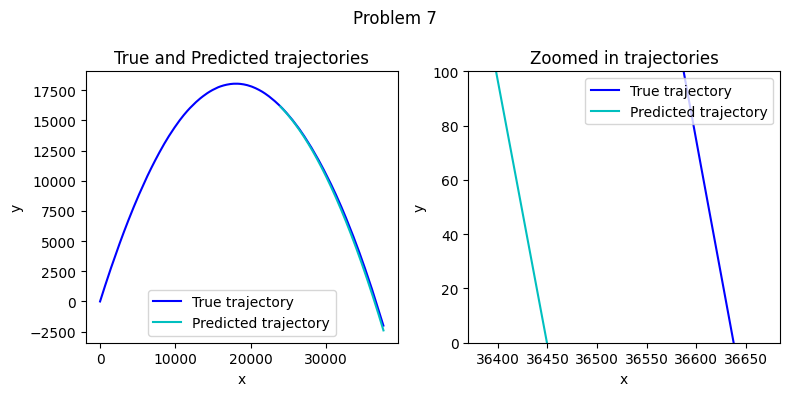

In [7]:
predicted = kf.predict(est[:,-1], 450)

# create a dynamic xlim to always plot both sequences together
x1 = states[0,:][np.where(states[1,:]>=0)][-1]
x2 = predicted[0,:][np.where(predicted[1,:]>=0)][-1]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[0,:], states[1,:], label="True trajectory", c="b")
plt.plot(predicted[0,:], predicted[1,:], label="Predicted trajectory", c="c")
plt.title("True and Predicted trajectories")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.plot(states[0,:], states[1,:], label="True trajectory", c="b")
plt.plot(predicted[0,:], predicted[1,:], label="Predicted trajectory", c="c")
plt.title("Zoomed in trajectories")
plt.xlim(min(x1,x2)-50, max(x1,x2)+50)
plt.ylim(0, 100)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.suptitle("Problem 7")
plt.tight_layout()
plt.show()

## Rewinding

We use the state estimate $\hat{\mathbf{x}}_{250}$ to predict the point of origin of the projectile along with all states leading up to time step 250. 
We plot these predicted states (in green) together with the original state sequence. 
We zoom in to see how accurate your prediction is. 
We then repeat the prediction starting with $\hat{\mathbf{x}}_{600}$ and compare to the previous results. 

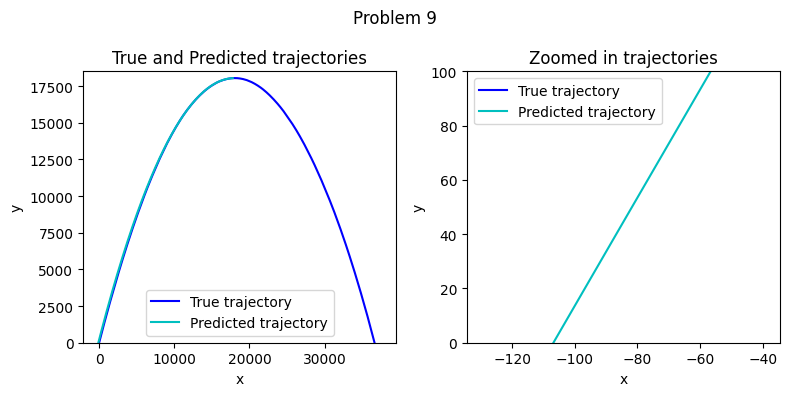

In [11]:
x = est[:, 399]
k = 605

rewind = kf.rewind(x, k)

# create a dynamic xlim to always plot both sequences together
x1 = states[0,:][np.where(states[1,:]>=0)][-1]
x2 = rewind[0,:][np.where(rewind[1,:]>=0)][-1]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(states[0,:], states[1,:], label="True trajectory", c="b")
plt.plot(rewind[0,:], rewind[1,:], label="Predicted trajectory", c="c")
plt.title("True and Predicted trajectories")
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, 18500)
plt.legend()

plt.subplot(1,2,2)
plt.plot(states[0,:], states[1,:], label="True trajectory", c="b")
plt.plot(rewind[0,:], rewind[1,:], label="Predicted trajectory", c="c")
plt.title("Zoomed in trajectories")
plt.xlim(min(x1,x2)-50, min(x1,x2)+50)
plt.ylim(0, 100)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.suptitle("Problem 9")
plt.tight_layout()
plt.show()

The second is better because the plots are closer together.